In [1]:
from IPython.display import clear_output
import joblib
import json
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
from PIL import Image
import random
from scipy import cluster
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from skimage.segmentation import mark_boundaries
from tqdm import tqdm

from Config import *
working_dir = get_working_dir()

In [2]:
with open('{}/dataset.json'.format(working_dir), 'r') as f:
    dataset = json.load(f)
dataset = dataset['test']

with open('{}/patches.json'.format(working_dir), 'r') as f:
    patches = json.load(f)

In [3]:
# Split the (testing) images into a train/test split for the PatchDetector
ids = {}
ids['train'], ids['test'] = train_test_split(list(dataset), test_size = 0.5)


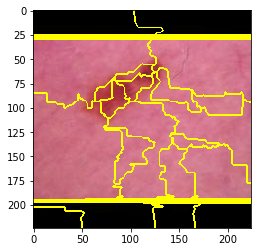

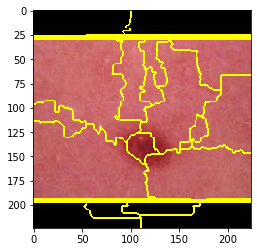

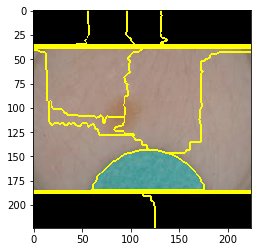

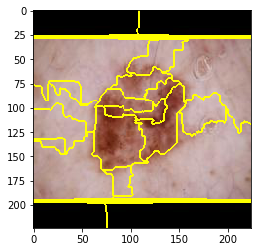

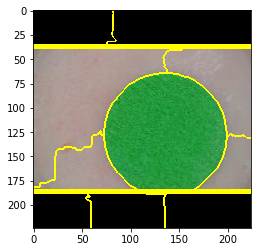

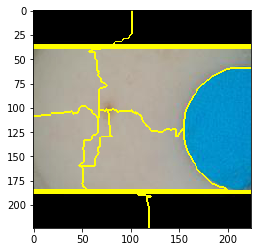

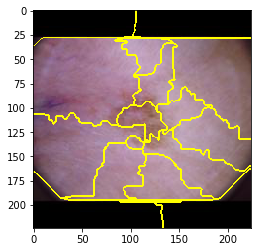

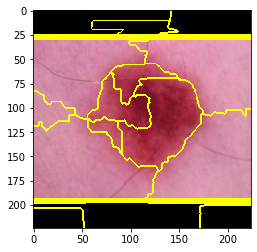

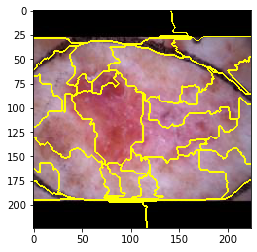

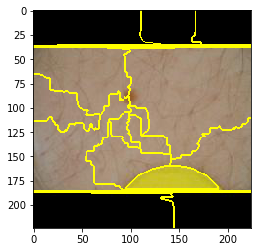

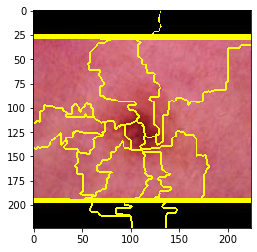

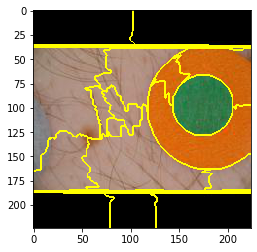

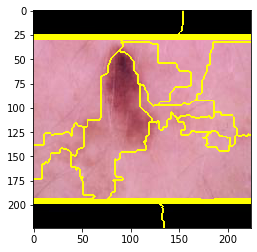

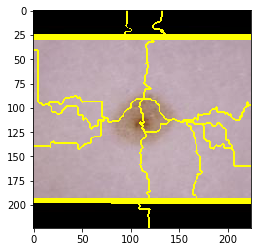

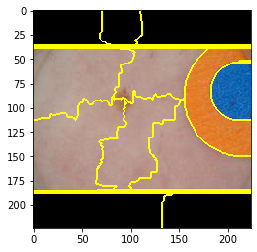

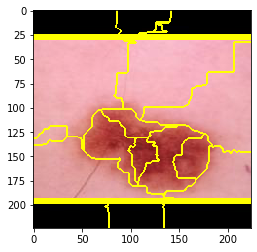

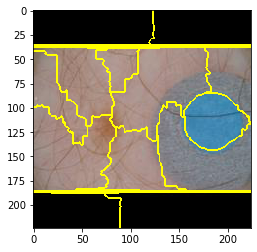

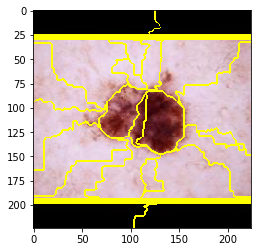

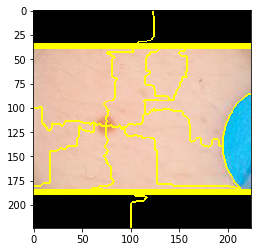

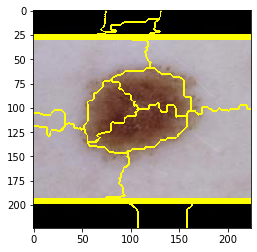

In [4]:
# Segment the training images
def worker(i):
    im = np.array(Image.open(dataset[i][0]))
    seg = get_seg(im)
    info = get_info(im, seg)
    return (im, seg, info, i)

for i in ids['train'][:20]:
    im, seg, info, i = worker(i)
    plt.imshow(im)
    plt.imshow(mark_boundaries(im, seg))
    plt.show()
    plt.close()

if __name__ == '__main__':
    p = Pool()
    results = p.map(worker, ids['train'])

    out = {}
    for (im, seg, info, i) in results:
        out[i] = info

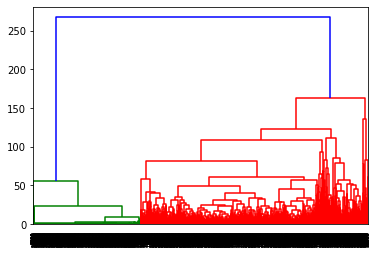

In [5]:
#  Run a hierarchical clustering on the mean RGB values for each segment
scores = []
masks = []
for i in out:
    for info in out[i]:
        scores.append(info[0])
        masks.append(info[2])
scores = np.array(scores)

linked = cluster.hierarchy.linkage(scores, 'average')

plt.figure()
cluster.hierarchy.dendrogram(linked)
plt.show()

0 3894


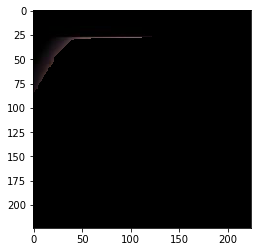

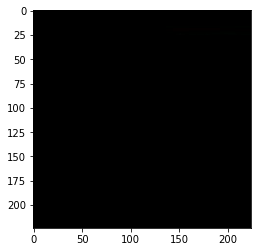

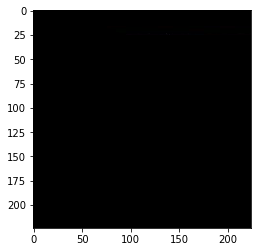

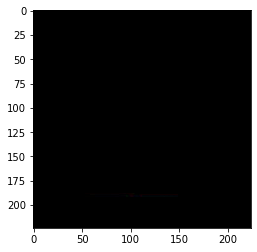

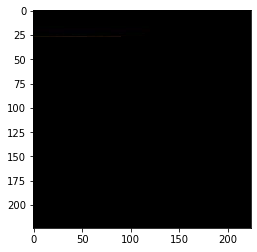

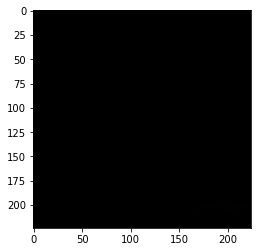

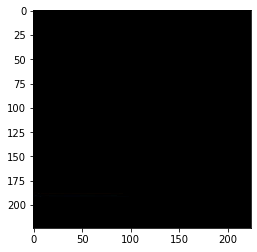

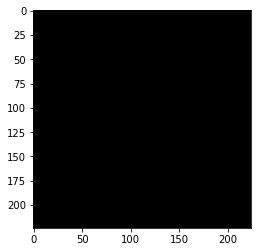

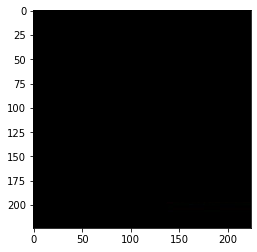

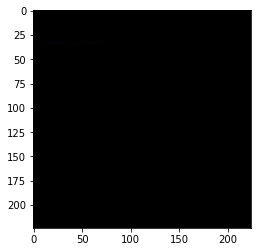





1 1036


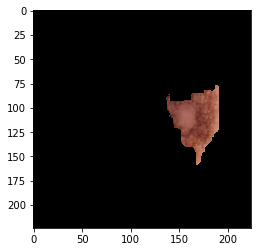

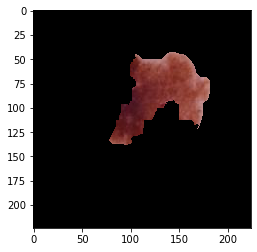

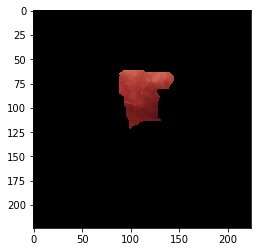

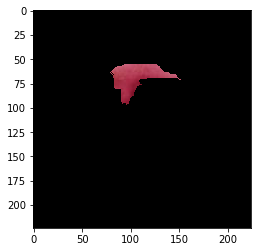

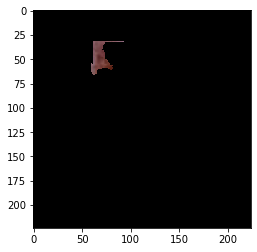

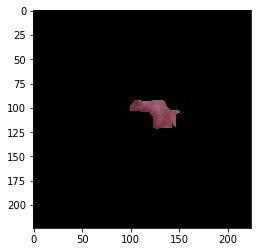

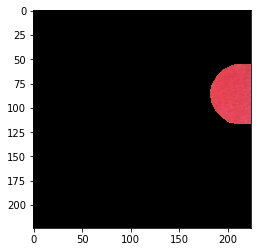

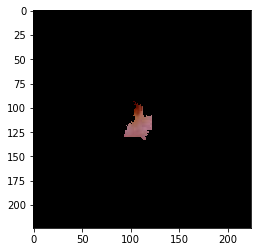

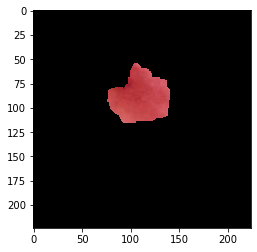

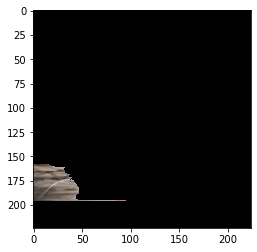





2 6433


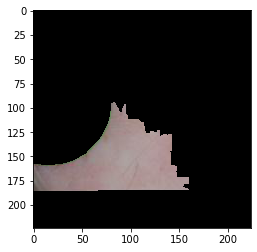

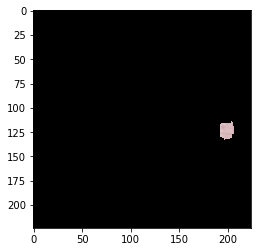

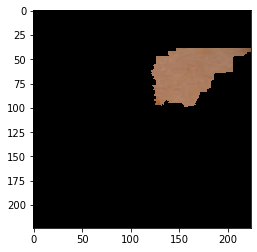

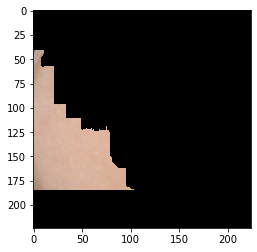

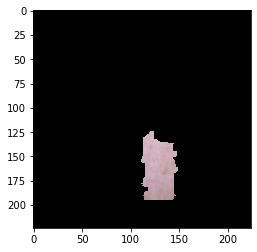

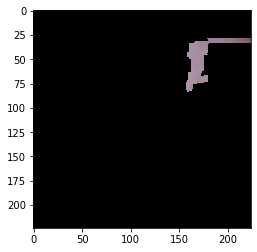

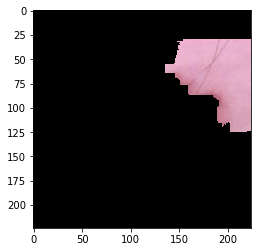

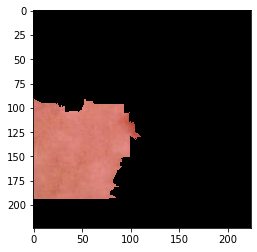

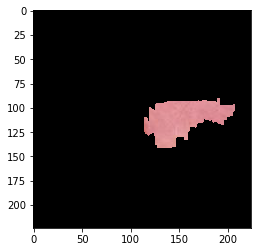

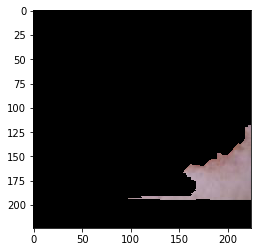





3 171


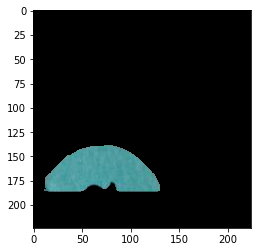

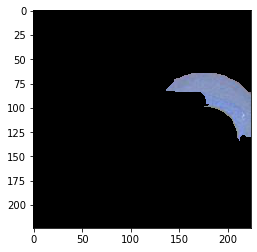

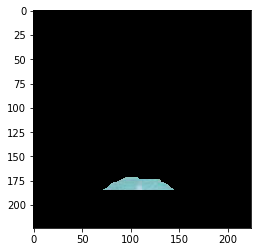

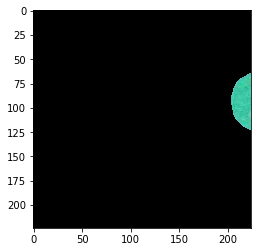

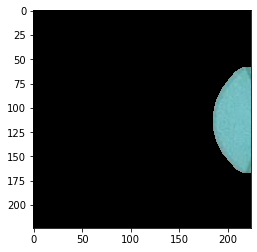

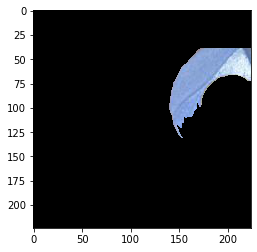

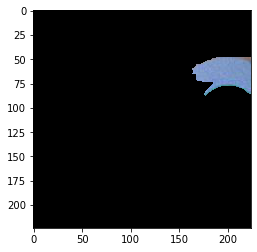

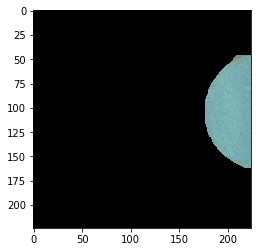

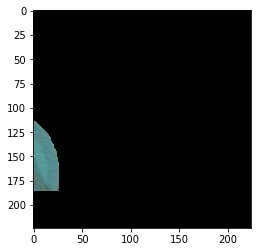

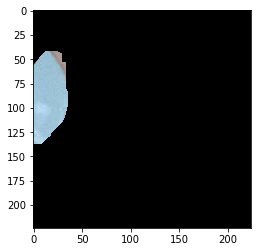





4 141


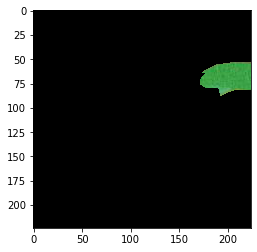

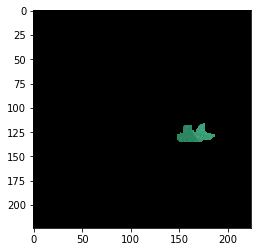

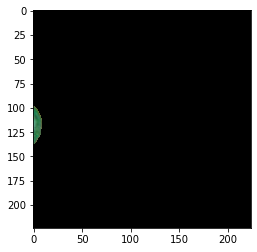

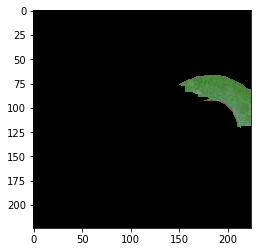

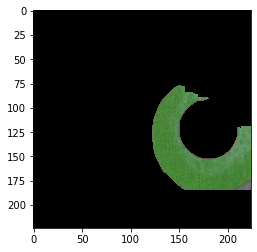

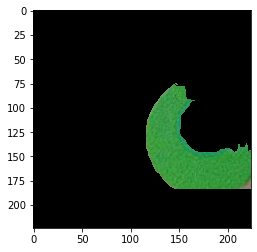

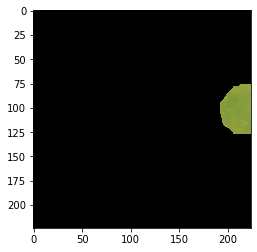

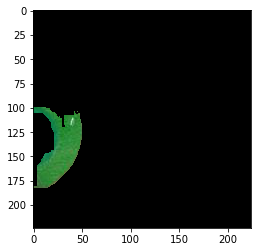

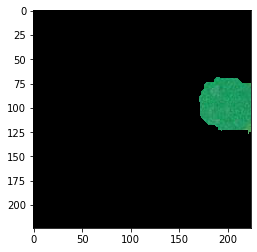

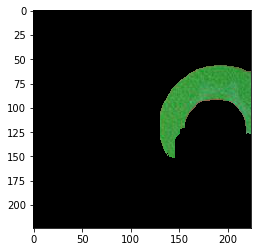





5 51


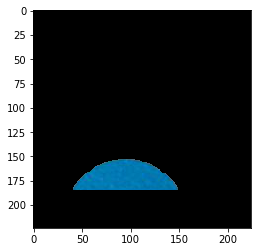

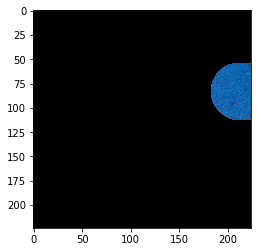

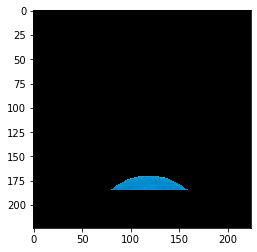

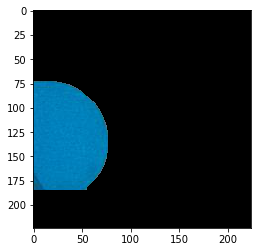

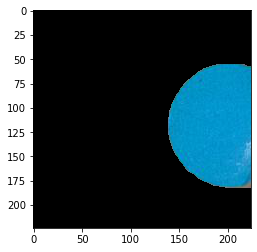

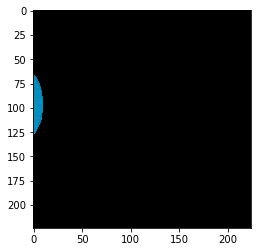

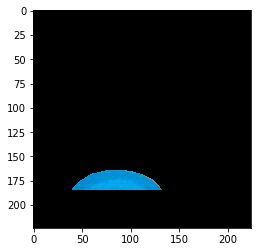

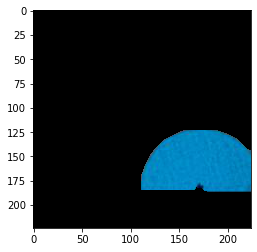

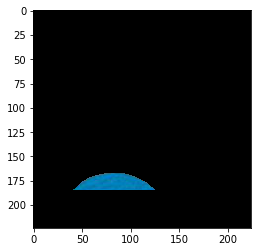

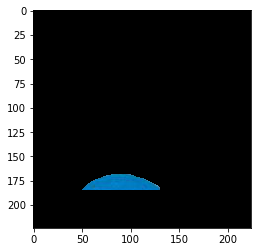





6 87


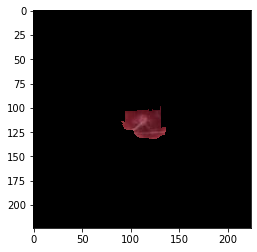

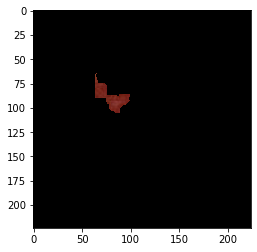

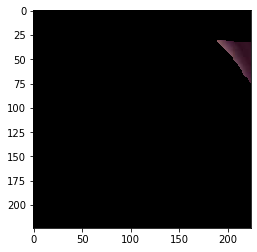

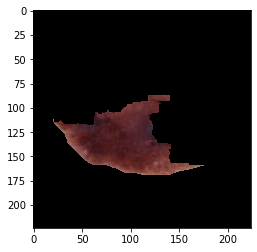

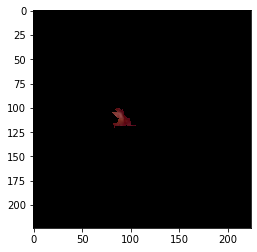

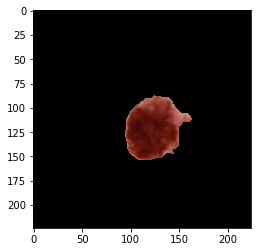

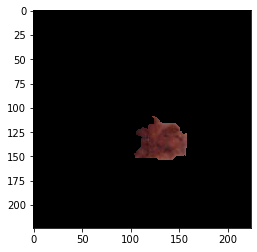

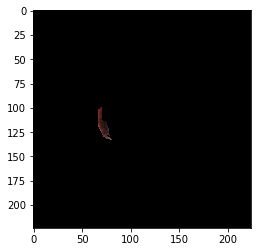

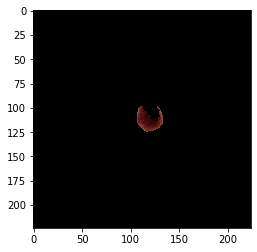

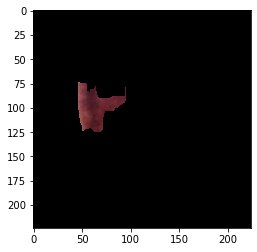





7 311


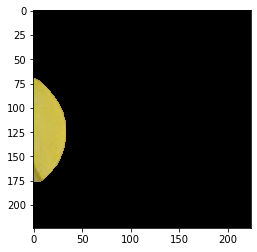

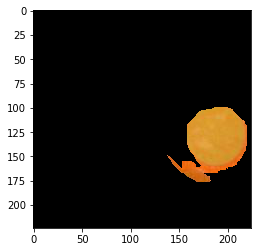

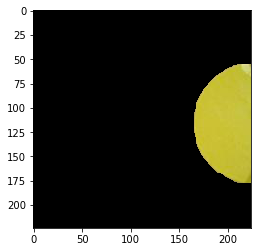

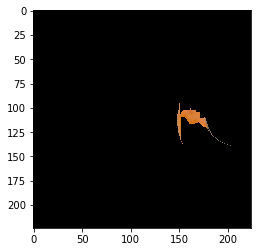

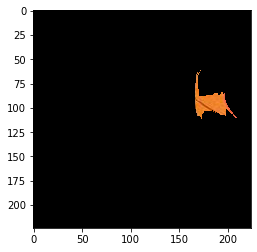

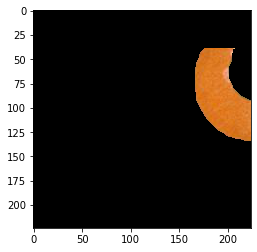

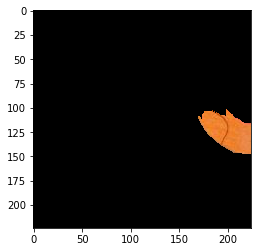

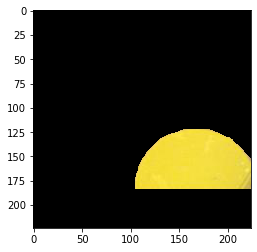

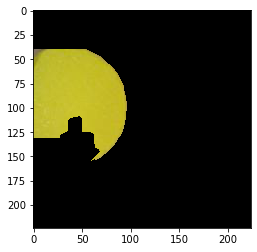

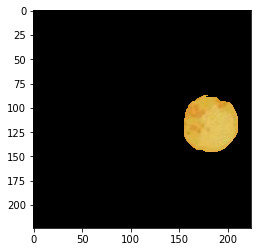





8 13


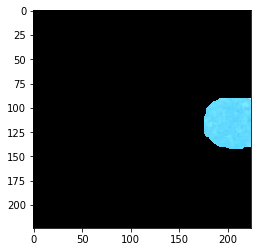

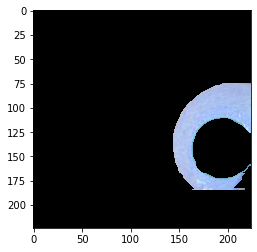

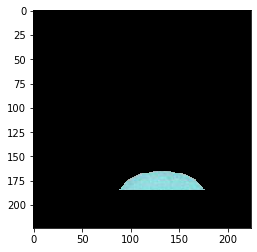

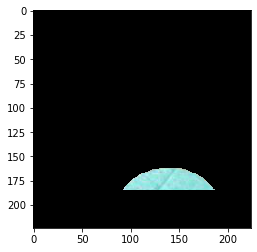

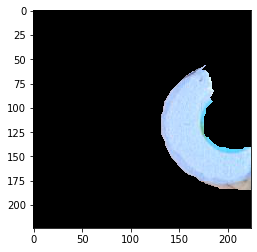

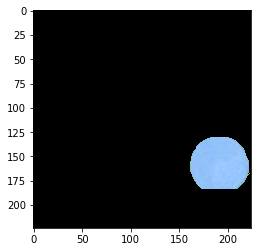

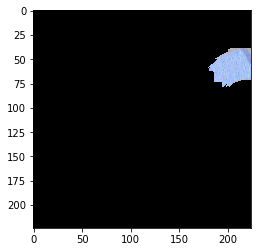

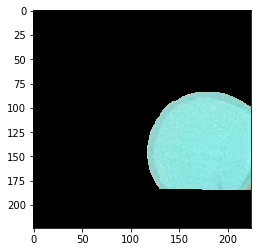

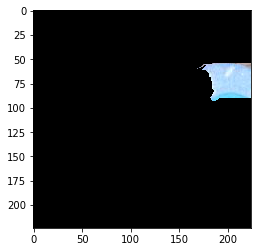

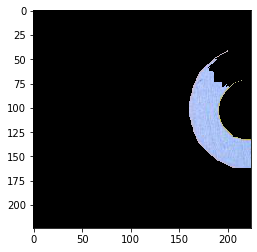

In [6]:
# Cut the hierarchical clustering 
n_clusters = 9

clusters = cluster.hierarchy.cut_tree(linked, n_clusters = n_clusters)
clusters = np.squeeze(clusters)

for i in range(n_clusters):
    indices = list(np.where(clusters == i)[0])  
    print(i, len(indices))
    sample = random.sample(indices, min(10, len(indices)))

    for index in sample:
        plt.imshow(masks[index])
        plt.show()
        plt.close()

    print()
    print()
    print()
    print()

In [7]:
clusters_patch = [3, 4, 5, 7, 8]

In [8]:
# Fitt a KNN to predict those clusters
indices = list(range(scores.shape[0]))
indices_train, indices_test = train_test_split(indices, test_size = 0.2)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(scores[indices_train, :], clusters[indices_train])
print('Train Acc:', knn.score(scores[indices_train, :], clusters[indices_train]))
print('Test Acc:', knn.score(scores[indices_test, :], clusters[indices_test]))

with open('./PatchDetector.joblib', 'wb') as f:
    joblib.dump([knn, clusters_patch], f)
    
pd = PatchDetector(knn, clusters_patch)

Train Acc: 0.9982490472757235
Test Acc: 0.9983525535420099


In [15]:
# Combine the per-segment predictions to get a per-image prediction
def worker(i):
    return (pd.predict(Image.open(dataset[i][0])), i)

if __name__ == '__main__':
    p = Pool()
    results = p.map(worker, ids['test'][:200])

    out = {}
    for (result, i) in results:
        out[i] = result
        
    tp = []
    fp = []
    tn = []
    fn = []
    for i in ids['test'][:200]:
        pred = out[i]['pred']
        label = patches[i]
        v = (i, out[i])
    
        if label == 1:
            if pred == 1:
                tp.append(v)
            else:
                fn.append(v)
        else:
            if pred == 1:
                fp.append(v)
            else:
                tn.append(v)  
                
    print('Recall:', len(tp) / (len(tp) + len(fn)))
    print('Precision:', len(tp) / (len(tp) + len(fp)))

Recall: 0.8672566371681416
Precision: 0.98989898989899


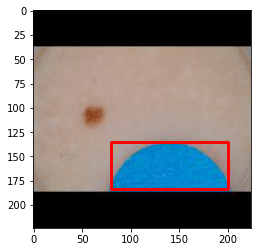

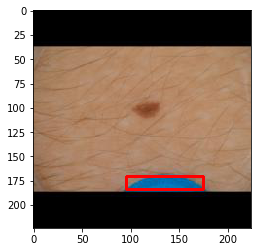

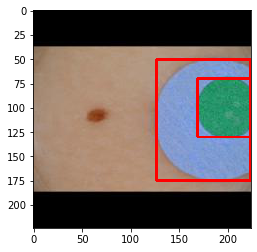

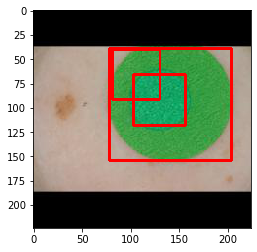

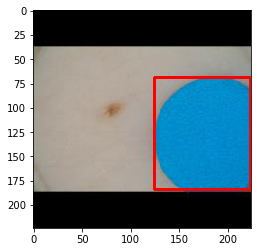

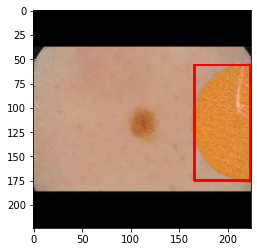

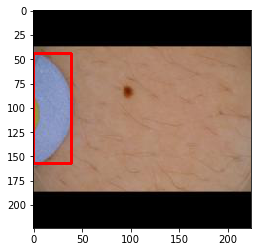

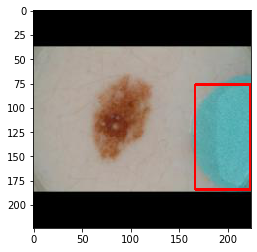

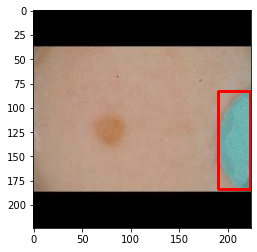

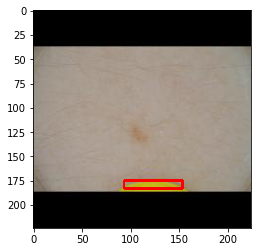

In [16]:
# Inspect True Postives
count = 0
for i in tp:
    plt.imshow(i[1]['cf'])
    plt.show()
    plt.close()
    
    count += 1
    if count == 10:
        break

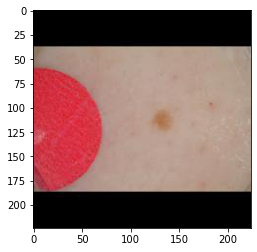

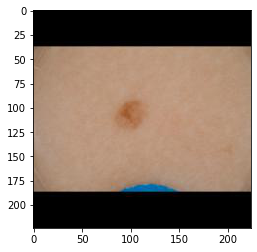

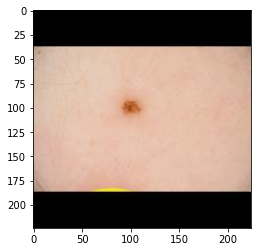

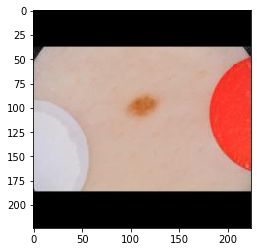

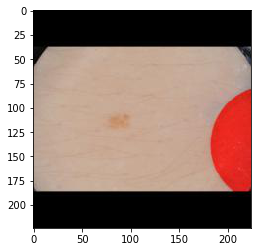

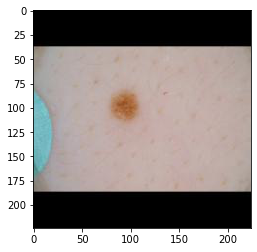

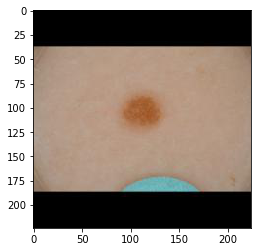

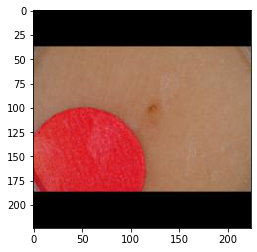

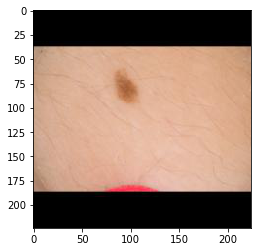

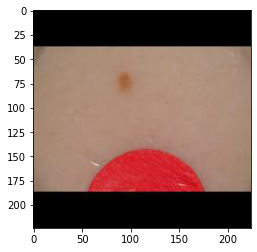

In [17]:
# Inspect False Negatives

count = 0
for r in fn:
    i = r[0]
    image = Image.open(dataset[i][0])
    
    plt.imshow(image)
    plt.show()
    plt.close()
    
    count += 1
    if count == 10:
        break



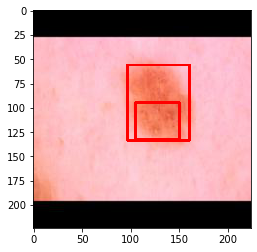

In [18]:
# Inspect False Positives

count = 0
for i in fp:
    plt.imshow(i[1]['cf'])
    plt.show()
    plt.close()
    
    count += 1
    if count == 10:
        break
    count += 1
    if count == 10:
        break
